# In this notebook I write the routine for TOF spectrum calibration

        What it should be done:
        - read the theoretical spectrum
        - read the calibration sample
        - be able to convert from TOF to lambda and back
        - calculate T0 and deltaL, which are the results of the calibration 
        
        time to lambda convertion:
            lambda = h/mL (t-t0)
            where:lambda = wavelength [A] (A=0.1nm = 1e-10m)
                    h = Planck's constant: 6.62607004 × 10-34 m^2 kg / s
                    m = Neutron mass [kg]: 1.674 927 471 x 10-27 kg 
                    L = total flight path [m]
                    t = time of flight [s]
                    
        

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import os, fnmatch
from os import listdir
%matplotlib inline
import scipy.signal
from scipy.signal import find_peaks
print(scipy.__version__)


1.1.0


In [68]:
# Constant values
h=6.62607004e-34 #Planck constant [m^2 kg / s]
m=1.674927471e-27 #Neutron mass [kg]
t0=0
L= 19 #[m]
dL = 0

In [4]:
def tof2l(tof):
    l=h/m*(tof-t0)/(L+dL)/1e-10
    return l

def l2tof(l):
    tof=t0+(l*1e-10)*(L+dL)*m/h
    return tof

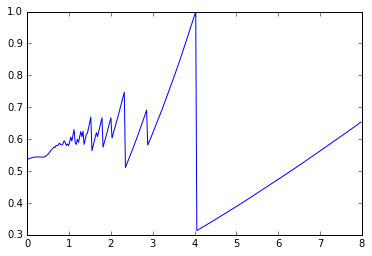

In [5]:
mylambda = np.genfromtxt('lambda.txt',usecols=0)
myspectrum = np.genfromtxt('alpha.txt',usecols=0)

# print(mylambda)
mytof = l2tof(mylambda)
relambda = tof2l(mytof)
plt.plot(relambda, myspectrum/max(myspectrum))
plt.show()


In [6]:
# Read the calibration spectrum from file
mycaltof = np.genfromtxt('/data/data2/RADEN_Feb2018/09_CalibrationSample/TEST10_097_Spectra.txt', usecols=0)
myhist = np.genfromtxt('/data/data2/RADEN_Feb2018/09_CalibrationSample/TEST10_097_Spectra.txt', usecols=1) #this is the cumulative histogram of the raw data (before the overlap correction)

# plt.plot(mytof,myhist)
# plt.show()

In [7]:
# Read the calibration datasets:
pathdata ="/data/data2/RADEN_Feb2018/09_CalibrationSample/cal_sample_corrected/"
pathOB = "/data/data2/RADEN_Feb2018/04_i_OB/"

In [8]:
myfiles = fnmatch.filter(listdir(pathdata),'*.fits')
coll_files = sorted(myfiles)

obfiles = fnmatch.filter(listdir(pathOB),'TEST*') # here there are several OB folders
coll_ob = sorted(obfiles)
# print(sorted(obfiles))

In [9]:
# normalized_sample = np.zeros([512,512,len(coll_files)])
obsubfiles = [None]*len(obfiles)

for i in range(0, len(obfiles)):
#     print(obfiles[i])
    obsubfiles[i]= sorted(fnmatch.filter(listdir(pathOB+obfiles[i]+'/Corrected'),'*.fits')) 

print(obsubfiles[2][0])

TEST5_065_00000.fits


In [10]:
cal_spectrum = np.zeros(len(coll_files))
cal_ob = np.zeros(len(coll_files))
ori_hist = np.zeros(len(coll_files))

for i in range(0, len(coll_files)):
    curr_img = (fits.open(pathdata+coll_files[i])[0].data).astype(float)
    curr_ob =np.zeros(np.shape(curr_img))
    norm_sample = np.zeros(np.shape(curr_img))
    for j in range(0, len(obfiles)):
#         print(pathOB+obfiles[j]+'/Corrected/'+obsubfiles[j][i])
        curr_ob += (fits.open(pathOB+obfiles[j]+'/Corrected/'+obsubfiles[j][i])[0].data).astype(float)
    
    curr_ob/=3
    norm_sample = np.divide(curr_img,curr_ob)
    ori_hist[i] = np.sum(curr_img)
#     normalized_sample[:,:,i] = np.divide(curr_img, curr_ob) #here something wrong happens
    cal_spectrum[i]= np.mean(norm_sample[~np.isnan(norm_sample) & ~np.isinf(norm_sample)]) # but the strange thing is that the division gives nan or inf.
    cal_ob[i]= np.mean(curr_ob)
    
    

/home/carminati_c/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in divide
/home/carminati_c/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in divide


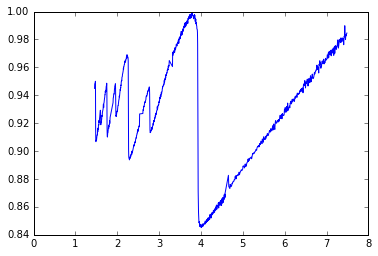

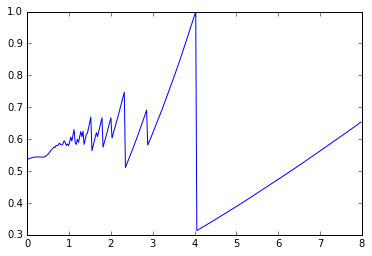

In [39]:
cal_spectrum_norm = -1*np.log(cal_spectrum)/np.max(-1*np.log(cal_spectrum))
mycalLambda = tof2l(mycaltof)
plt.plot(mycalLambda, cal_spectrum_norm)
plt.xlim(0,8)
plt.show()

myspectrum_norm = myspectrum/np.max(myspectrum)
plt.plot(mylambda, myspectrum_norm)
plt.xlim(0,8)
plt.show()

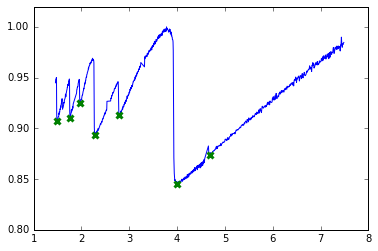

[1.49159972 1.76450777 1.97145415 2.29127244 2.78588079 4.00550526
 4.68989914]


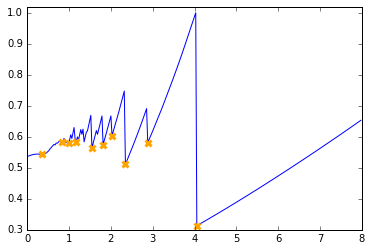

[0.347 0.827 0.987 1.173 1.547 1.813 2.027 2.347 2.88  4.053]


In [118]:
peaks, _ = find_peaks(-cal_spectrum_norm, width=10)
plt.plot(mycalLambda, cal_spectrum_norm)
plt.plot(mycalLambda[peaks],cal_spectrum_norm[peaks],'x', markeredgewidth=3)
plt.ylim(0.8,1.02)
plt.show()
print(mycalLambda[peaks])

peaks_th, _ = find_peaks(-myspectrum_norm, width=2)
plt.plot(mylambda, myspectrum_norm)
plt.plot(mylambda[peaks_th],myspectrum_norm[peaks_th],'x', markeredgewidth=3, c='orange')
plt.ylim(0.3,1.02)
plt.show()
print(mylambda[peaks_th])

## I will then fit the calculated TOF to the theoretical lambda, x= mylambda y=mycaltof 

[ 0.00479309 -0.00026187]
[1.49159972 1.76450777 1.97145415 2.29127244 2.78588079 4.00550526]
[1.547 1.813 2.027 2.347 2.88  4.053]


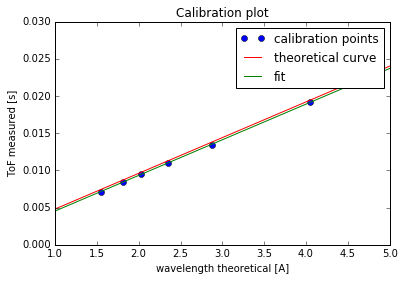

In [140]:
z = np.polyfit(mylambda[peaks_th[4:]],mycaltof[peaks[0:6]],1) # here I have to select which peaks to be used
print(z)
print(mycalLambda[peaks[0:6]])
print(mylambda[peaks_th[4:]])


plt.plot( mylambda[peaks_th[4:]],mycaltof[peaks[0:6]],'ob')
plt.plot( mylambda, mytof,'-r')
plt.plot(mylambda, mylambda*z[0]+z[1],'-g')
plt.xlim(1,5)
plt.xlabel('wavelength theoretical [A]')
plt.ylabel('ToF measured [s]')
plt.ylim(0.0,0.03)
plt.legend(['calibration points','theoretical curve', 'fit'])
plt.title('Calibration plot')


In [136]:
T0 = z[1]
L = (z[0]*h/m)/1e-10
print(T0,L)

(-0.0002618673892937752, 18.961609065251505)
